In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import dash
#from dash import html, dcc
#from dash.dependencies import Input, Output
from sklearn.preprocessing import LabelEncoder
import pickle
import dash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc

In [2]:
# Read the data set into a data frame
diaPred = pd.read_csv("early+stage+diabetes+risk+prediction+dataset.zip")

# View the data frame
diaPred.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [3]:
# Drop NA
diaPred.dropna(inplace = True)

# Get insight
diaPred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [4]:
# Encode categorical features
binary_cols = diaPred.columns[1:]  # Exclude 'Age' since it's numeric
encoder = LabelEncoder()
for col in binary_cols:
    diaPred[col] = encoder.fit_transform(diaPred[col])

# View the new data frame
diaPred.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


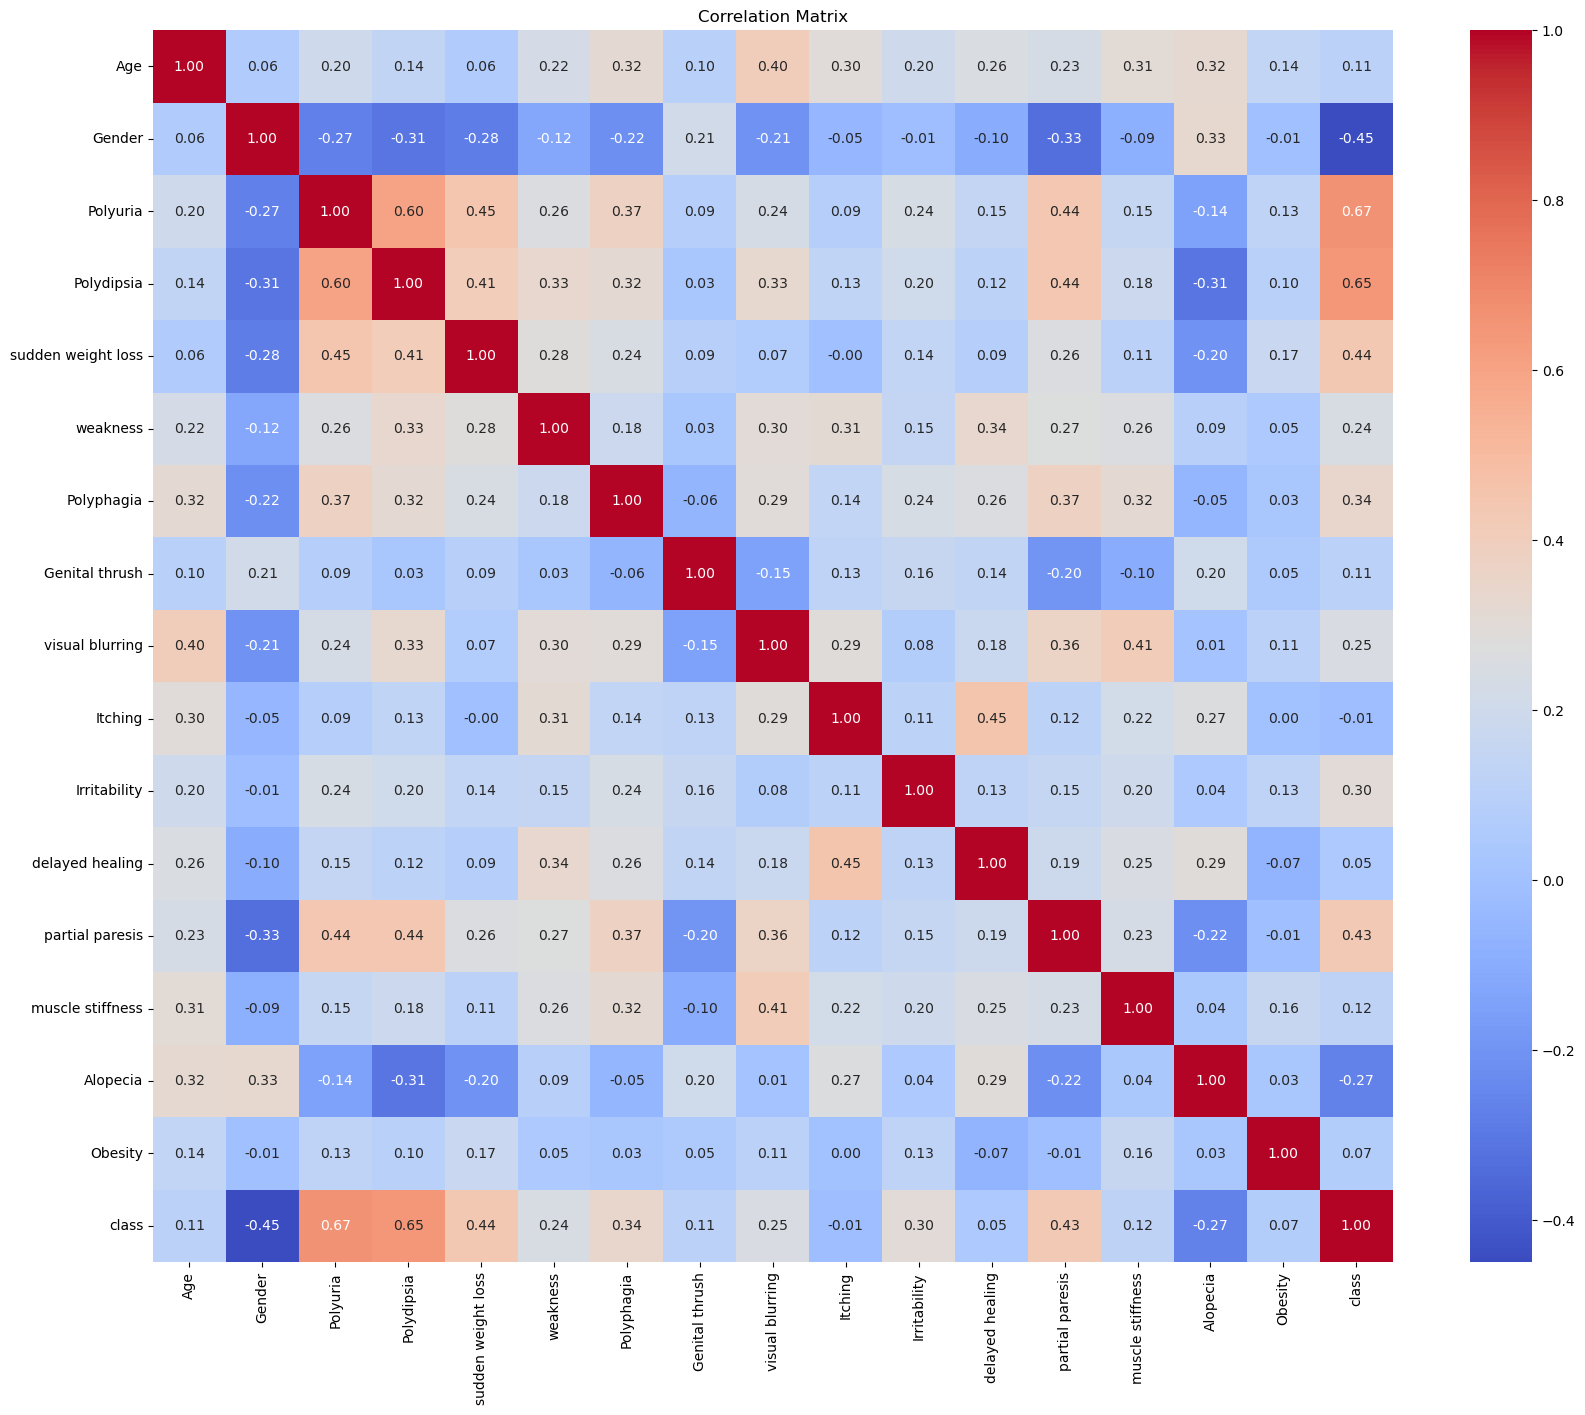

In [5]:
# Plot the correlation matrix of the main numerical features
plt.subplots(figsize=(20, 16))

sns.heatmap(diaPred.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix");

In [6]:
# Split the data set for modelling
X = diaPred.drop(columns = "class")
y = diaPred["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Training and evaluating a Baseline Model to set a benchmark for our models
acc_baseline = (y_train.value_counts(normalize = True).max())*100
print("Baseline Accuracy:", round(acc_baseline, 2),"%")

Baseline Accuracy: 59.86 %


In [7]:
# Instantiate the Random Forest Regressor model
randomModel = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

#Fit the model
randomModel.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

In [8]:
random_y_pred = randomModel.predict(X_test)
accuracy = accuracy_score(y_test, random_y_pred) * 100
print("Random Forest Classifier Accuracy:", round(accuracy, 2), "%") #75.11

Random Forest Classifier Accuracy: 100.0 %


In [9]:
# Save model for future use
with open("Early Stage Diabetes Model.pkl", "wb") as file:
    pickle.dump(randomModel, file)

In [10]:
# The model classification report
print("Random Forest Classifier Classification Report:\n", classification_report(y_test, random_y_pred))

Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        71

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



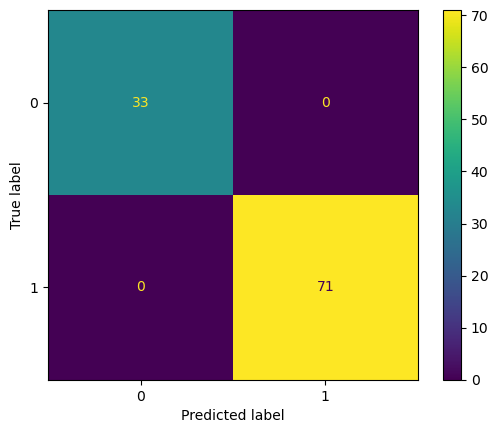

In [11]:
# Plot the model confusion Matrix
ConfusionMatrixDisplay.from_estimator(randomModel, X_test, y_test);

In [12]:
# Combine all feature names into a single list
feature_names = X.columns

# Get features' importance values
importances = randomModel.feature_importances_.round(2)

# Create a DataFrame to view feature importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
importance_df.set_index("Feature", inplace=True)

# Print the top 5 feature importance
importance_df.head()

,Importance
Feature,
Polyuria,0.24
Polydipsia,0.18
Gender,0.11
Age,0.09
sudden weight loss,0.05


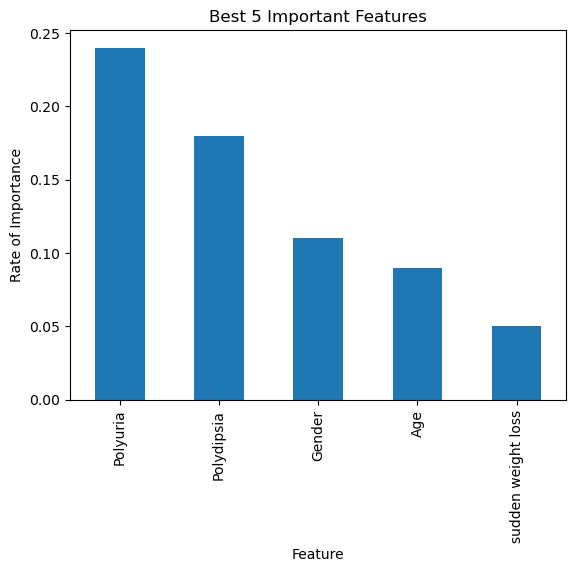

In [13]:
# Plot the top 5 feature importance
importance_df.head(5).plot(kind = "bar",
                           ylabel = "Rate of Importance",
                           title = "Best 5 Important Features",
                           legend = False);

In [14]:
# Load the pre-trained model
with open("Early Stage Diabetes Model.pkl", "rb") as file:
    model = pickle.load(file)

# Initialize Dash app
app = dash.Dash(__name__)

# Dropdown options for categorical features
yes_no_options = ["Yes", "No"]
gender_options = ["Male", "Female"]

In [19]:
# Layout
app.layout = dbc.Container([
    html.H1("Early Stage Diabetes Prediction Dashboard", style={'textAlign': 'center'}),
        dbc.Row([
            dbc.Col([
                html.Label("Age"),
                dcc.Input(id='age', type='number', placeholder="Enter Age", min=1),
            ]),
            dbc.Col([
                html.Label("Gender"),
                dcc.Dropdown(id='gender', options=[{'label': g, 'value': g} for g in gender_options], placeholder="Select Gender"),
            ]),
            dbc.Col([
                html.Label("Polyuria"),
                dcc.Dropdown(id='polyuria', options=[{'label': opt, 'value': opt} for opt in yes_no_options], placeholder="Select Polyuria"),
            ]),
        ]),
            
        dbc.Row(
            [
                dbc.Col([
                    html.Label("Polydipsia"),
                    dcc.Dropdown(id='polydipsia', options=[{'label': opt, 'value': opt} for opt in yes_no_options], placeholder="Select Polydipsia"),
                ]),
                dbc.Col([
                    html.Label("Sudden Weight Loss"),
                    dcc.Dropdown(id='sudden_weight_loss', options=[{'label': opt, 'value': opt} for opt in yes_no_options], 
                                 placeholder="Select Sudden Weight Loss"),
                ]),
            ],
        ),
              
        dbc.Row(
            [
                dbc.Col([
                    html.Label("Weakness"),
                    dcc.Dropdown(id='weakness', options=[{'label': opt, 'value': opt} for opt in yes_no_options],
                                 placeholder="Select Weakness"),
                ]),
                    
                dbc.Col([
                    html.Label("Polyphagia"),
                    dcc.Dropdown(id='polyphagia', options=[{'label': opt, 'value': opt} for opt in yes_no_options],
                                 placeholder="Select Polyphagia"),
                ]),
                    
                dbc.Col([
                    html.Label("Genital Thrush"),
                    dcc.Dropdown(id='genital_thrush', options=[{'label': opt, 'value': opt} for opt in yes_no_options], 
                                 placeholder="Select Genital Thrush"),
                ]),
            ]
        ),
              
        dbc.Row(
            [
                dbc.Col([
                    html.Label("Visual Blurring"),
                    dcc.Dropdown(id='visual_blurring', options=[{'label': opt, 'value': opt} for opt in yes_no_options], 
                                 placeholder="Select Visual Blurring"),
                ]),
                dbc.Col([
                    html.Label("Itching"),
                    dcc.Dropdown(id='itching', options=[{'label': opt, 'value': opt} for opt in yes_no_options],
                                 placeholder="Select Itching"),
                ]),
                dbc.Col([
                    html.Label("Irritability"),
                    dcc.Dropdown(id='irritability', options=[{'label': opt, 'value': opt} for opt in yes_no_options],
                                 placeholder="Select Irritability"),
                ]),
                dbc.Col([
                    html.Label("Delayed Healing"),
                    dcc.Dropdown(id='delayed_healing', options=[{'label': opt, 'value': opt} for opt in yes_no_options],
                                 placeholder="Select Delayed Healing"),
                ]),
            ]
        ),
              
        dbc.Row(
            [
                dbc.Col([
                    html.Label("Partial Paresis"),
                    dcc.Dropdown(id='partial_paresis', options=[{'label': opt, 'value': opt} for opt in yes_no_options],
                                 placeholder="Select Partial Paresis"),
                ]),
                dbc.Col([
                    html.Label("Muscle Stiffness"),
                    dcc.Dropdown(id='muscle_stiffness', options=[{'label': opt, 'value': opt} for opt in yes_no_options],
                                 placeholder="Select Muscle Stiffness"),
                ]),
                dbc.Col([
                    html.Label("Alopecia"),
                    dcc.Dropdown(id='alopecia', options=[{'label': opt, 'value': opt} for opt in yes_no_options],
                                 placeholder="Select Alopecia"),
                ]),
                dbc.Col([
                    html.Label("Obesity"),
                    dcc.Dropdown(id='obesity', options=[{'label': opt, 'value': opt} for opt in yes_no_options], placeholder="Select Obesity"),
                ]),
            ]
        ),
   # ]
    #        ),
    
    dbc.Button("Predict", id='predict-button', n_clicks=0, color="primary", style={"marginTop": "20px"}),
    html.Div(id='output-prediction', style={'textAlign': 'center', 'marginTop': '20px'}),
    
    ],
    fluid=True,
)

In [20]:
# Callback for prediction
@app.callback(
    Output('output-prediction', 'children'),
    [Input('age', 'value'),
     Input('gender', 'value'),
     Input('polyuria', 'value'),
     Input('polydipsia', 'value'),
     Input('sudden_weight_loss', 'value'),
     Input('weakness', 'value'),
     Input('polyphagia', 'value'),
     Input('genital_thrush', 'value'),
     Input('visual_blurring', 'value'),
     Input('itching', 'value'),
     Input('irritability', 'value'),
     Input('delayed_healing', 'value'),
     Input('partial_paresis', 'value'),
     Input('muscle_stiffness', 'value'),
     Input('alopecia', 'value'),
     Input('obesity', 'value'),
     Input('predict-button', 'n_clicks')]
)
def predict_diabetes(age, gender, polyuria, polydipsia, sudden_weight_loss, weakness, polyphagia, genital_thrush,
                     visual_blurring, itching, irritability, delayed_healing, partial_paresis, muscle_stiffness,
                     alopecia, obesity, n_clicks):
    if n_clicks > 0:
        if None in [age, gender, polyuria, polydipsia, sudden_weight_loss, weakness, polyphagia, genital_thrush,
                    visual_blurring, itching, irritability, delayed_healing, partial_paresis, muscle_stiffness,
                    alopecia, obesity]:
            return "Please fill in all the fields."

        # Prepare the input data
        input_data = pd.DataFrame([{
            "Age": age,
            "Gender": gender,
            "Polyuria": polyuria,
            "Polydipsia": polydipsia,
            "sudden weight loss": sudden_weight_loss,
            "weakness": weakness,
            "Polyphagia": polyphagia,
            "Genital thrush": genital_thrush,
            "visual blurring": visual_blurring,
            "Itching": itching,
            "Irritability": irritability,
            "delayed healing": delayed_healing,
            "partial paresis": partial_paresis,
            "muscle stiffness": muscle_stiffness,
            "Alopecia": alopecia,
            "Obesity": obesity
        }])

        # Ensure consistent preprocessing (e.g., label encoding for categorical variables)
        le_gender = LabelEncoder().fit(["Male", "Female"])
        input_data["Gender"] = le_gender.transform(input_data["Gender"])
        for col in input_data.columns[2:]:
            input_data[col] = input_data[col].map({"Yes": 1, "No": 0})

        # Predict
        prediction = model.predict(input_data)[0]
        return f"Predicted Class: {'Diabetic' if prediction == 1 else 'Non-Diabetic'}"
    return ""

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)